# 1. Problem and Data

The aim of this project is detecting fradulent activity in a real-world dataset of credit card transactions. The dataset contains 284,807 transactions, only 492 of which are labeled fradulent, or 0.172%. Due to confidentiality, this dataset has been transformed from its original form and only provides time and amount of each transaction along with 28 principal components of the original features obtained by PCA. Some information is inevitably lost during this transformation which limits how well any algorithm can do on this dataset compared to similar non-transformed datasets. It also renders feature engineering virtually irrelevant, as I discuss below in more detail.


# 2. Choosing an Evaluation Metric

Before we build our model, we need to choose an evaluation metric to measure the performance of different models with. For reasons explained below, I will evaluate models based on the highest recall rate they can acheive subject to precision being above a given minimum, say 5%. The idea behind this evaluation metric is that we want to focus on and maximize recall (probability of detecting fraud). But since higher recall (i.e. a more sensitive classifier) will inevitably result in lower precision (more false positives) we also want to make sure that precision does not get too low. So, we preset a level of precision and then try to maximize the probability of detecting fraudulent transactions, that is, the recall rate. I will call this metric **Conditional Recall**.

## 2.1 Further Details on Evaluation Metrics


I will briefly explain the reason for this choice, and why Conditional Recall is a better evaluation metric in this context than more commonly used alternatives such as AUC, PRAUC and F-score.

In choosing the evaluation metric we need to take two important features of the problem into account:

1. The evaluation metric needs to be robust to class imbalance and provide a reasonable measure of performance in the presence of this highly skewed class distribution (as only 0.172% of transactions are fraudulent)

2. It needs to incorporate the fact that false negatives (failing to detect fraud) are more costly than false positives (labeling a legal transaction as fraud).

The first consideration rules out some common metrics, such as accuracy and AUC (area under ROC curve) as these are not robust to class imbalance (Davis and Goadrich 2006). On the other hand, precision and recall have been shown to be robust to highly skewed class distributions and that is why a metric based on these statistics is more suitable for the present context.

PRAUC (area under precision-recall curve) and F-score are two of the most commonly used metrics that combine precision and recall into one single metric. However, they do not satisfy the second criterion. PRAUC gives the same weight to the performance of a classifier at all levels of precision and recall, whereas we care more about performance at high recall rates. In other words, a classifier with very high precision at low levels of recall can acheive a very high PRAUC score while it is practically useless for fraud detection purposes. F-score is more flexible in that we can give more weight to recall but I will not use this metric as it requires making ad-hoc assumptions about the context of the problem and the relative costs of false positives and false negatives.

On the other hand, Conditional Recall allows us to focus on improving the ability of the algorithm to detect fraud (i.e., its recall) in a transparent and easy-to-interpret way, while maintaining a decent level of precision.



# 3. Preprocessing

To address the extreme class imbalance in the data, I will use two different preprocessing techniques. For the XGBoost algorithm, I simply reweight the instances of the positive class (fraudulent transactions) by the class imbalance ratio. In the case of Logistic regression (one of the algorithms to which I will compare XGBoost), I use the **Synthetic Minority Over-sampling Technique (SMOTE)**. SMOTE balances the class distribution by creating new synthetic instances of the minority class.

However, I do not perform any further feature engineering (beyond rescaling for Logistic regression) for the following two reasons:

1. There are no missing values in this dataset and hence no need for imputing missing values. All variables are continuous numerical values.

2. XGBoost is an ensemble learning algorithm whose individual learning units are decision trees and trees have two favorable features which, again, render feature engineering unnecessary. First, decision trees are invariant to monotonic transformations of features (e.g. scaling or polynomial transformations). Second, they can inherently capture and model interactions between features. So, we do not need to manually create feature interactions.

3. As I mentioned above, the PCA transformation makes it impossible to use our background knowledge about the features to create new ones. Moreover, we do not need to worry about feature correlation as principal components are, by construction, orthogonal and therefore uncorrelated with one another.

Therefore, I will primarily focus on tuning the learning algorithm and try to optimize its performance through hyper-parameter optimization.

# 4. The XGBoost Algorithm

XGBoost or Extreme Gradient Boosting is an efficient implementation of the gradient boosting algorithm. Gradient boosting is an ensemble learning algorithm that sequentially trains weak learners (i.e. simple models, typically shallow decision trees) with an emphasis on the parts of the data that have not been captured well so far. The final prediction of the model is a weighted average of the predictions of these weak learners. XGBoost has been repeatedly shown to be very effective in a wide variety of both regression and classification tasks.

# 5. Overview of The Method

I will first split the data into a training and a held-out test set. The test will only be used once at the very end of the model building process to provide an unbiased estimate of model performance on data it has never seen before.

I will then build and test the model through the following steps:

1. Tuning by cross validation: Given the relatively large number of hyper-parameters of XGBoost, I will use Bayesian hyper-parameter tuning (which is more efficient than grid or random search), with (stratified) K-fold cross validation to choose the set of hyper-parameters that acheive the highest cross validated Conditional Recall score.

2. Thresholding: The tuned classifier from step (1) is able to predict a probability score for any given example. In order to classify an example we need to choose a probability threshold above which examples are labeled as positive (fraud). The standard practice is to set the threshold at 0.5. However, given the relative importance of recall over precision, we can use empirical thresholding (Sheng and Ling, 2006) to tune the trade off between precision and recall and possibily acheive a higher recall rate by choosing an appropriate classification threshold.

3. Training and testing: I will train the model on the entire training set and evaluate its performance on the test set using the Conditional Recall metric discussed above.

I will also compare the performance of this model with a few other algorithms at the end. In order to compare different models (e.g. XGBoost vs Logistic Regression) one would ideally use nested cross validation. However, this is computationally very expensive. So, I will only report the performance of these model on a single test set.

# Setting up the workspace

Let us start by setting up our workspace. This will import all the packages needed and initialize a global constant for minimum precision

In [ ]:
import pandas as pd
import numpy as np
# For Bayesian hyper-parameter optimization
import hyperopt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer, precision_recall_curve, recall_score, precision_score
from functools import partial
# To supress a deprecation warning caused due to an issue between XGBoost and SciPy
import warnings

MIN_PRECISION = 0.05

# The current version of XGBoost uses a conditional statement that
# the current version SciPy (internally used by XGBoost) doesn't like.
# This suppresses SciPy's deprecation warning message
warnings.filterwarnings('ignore')

# 6. Tuning by Cross Validation

In this first step, I will search for the best parameter combination for the XGBoost algorithm, using K-fold cross validation.

Before we get into the details of parameter optimization, a caveat about how I use data for cross validation is in order. XGBoost offers a useful feature called early stopping, which helps prevent overfitting due to growing too many trees. At every iteration, it evaluates the performance of the model so far on a validation set. It keeps training until the error on this validation set, which I will call early stopping set, fails to improve for a given number of iterations. This means that we are optimizing the number of trees as we train the model. But that also means that we cannot use that same set to evaluate the model. Otherwise we would overfit (the number of trees parameter) and the cross validation score will be biased upwards. That is why we need a separate validation set for early stopping, in addition to the (rotating) validation set used in cross validation.

Therefore, to prevent the early stopping feature from overfitting, in addition to splitting the data into a training and a test set, I also set aside a small portion of the training set to be used as the early stopping validation set.

## 6.1 Bayesian Hyper-Parameter Optimization

Bayesian hyper-parameter optimization starts by assuming a prior distribution for parameters of the model. At every iteration, it tries to learn from the previously evaluated parameter values to update this distribution and pick values that are more likely to yield high scores for future trials. This is in contrast to random and grid search, which blindly search the parameter space without learning from previous trials to guide the search. And for this reason, Bayesian hyper-parameter tuning has been shown to be more efficient than both random search and grid search, especially when evaluating the objective function is computationally costly and time-consuming and/or when we face a high-dimensional parameter-space.

## 6.2 Hyper-parameter Optimization With Hyperopt

I will use the Hyperopt package, which implements Bayesian optimization, to tune the hyper-parameters of the model.

### 6.2.1 The Objective Function

In order for Hyperopt to optimize the model, we first need to define the objective function to be optimized. In this case, the objective is simply the cross validated score of the model, given the hyper-parameter combination that we want to evaluate.

In [ ]:
def objective(params, X, y, X_early_stop, y_early_stop, scorer, n_folds = 10):

    pos_count = y_train.sum()
    neg_count = len(y_train) - pos_count
    imbalance_ratio = neg_count / pos_count
    
    xgb_clf = XGBClassifier(**params, scale_pos_weight=imbalance_ratio,
                            n_estimators = 2000, n_jobs = 1, 
                            early_stopping_rounds = 50, eval_metric = 'logloss')

    xgb_fit_params = {'eval_set': [(X_early_stop, y_early_stop)],
                      'verbose': False}
    
    cv_score = np.mean(cross_val_score(xgb_clf, X_train, y_train, cv = n_folds,
                               fit_params = xgb_fit_params, n_jobs = -1,
                               scoring = scorer))
    
    # hypoeropt minimizes the loss, hence the minus sign behind cv_score
    return {'loss': -cv_score, 'status': hyperopt.STATUS_OK, 'params': params}

This objective function will be called at every iteration of the Bayesian search to evaluate the model for a particular combination of hyper-parameters. It receives the paramter combination that we want to try in that iteration (as `params`) and a scorer function (defined later), initializes the `XGBClassifier` with those parameters and returns its K-fold (10-fold by default) cross validated score. The negative of score is returned (as loss) because Hyperopt minimizes the objective while we want the score to be maximized. For more details see Hyperopt documentation.

There are a few additional points worth noting about this function. First, the `scale_pos_weight` parameter of `XGBClassifier` is used to weight the positive examples (instances of fraud) by the class imbalance ratio. This increases the contribution of (the gradient of) positive examples to the loss function that XGBoost minimizes in order to compensate for the highly imbalanced class distribution.

The `xgb_fit_params` dictionary contains the input arguments that will be passed to the `fit` method of `XGBClassifier`. These parameters control the early stopping behaviour of XGBoost. XGBoost provides a useful early stopping functionality that can prevent overfitting due to growing too many trees. At every training iteration, it evaluates the algorithm's performance on a validation set (`X_early_stop` and `y_early_stop` here) and stops training when the resulting score (measured by the metric provided through `eval_metric`) does not improve for a given number of consecutive rounds (set via `early_stopping_rounds` argument). In other words, the training stops just before training and validation error start to diverge, beyond which we would be likely to overfit.

### 6.2.2 Implementing The Evaluation Metric

The Conditional Recall metric, which will be passed through the `scorer` argument of the objective function is defined as follows. It simply takes the precision-recall curve and find the recall rate corresponding to the given precision. The default precision level is set to 0.05, but can be changed, if needed.

In [ ]:
def conditional_recall_score(y_true, pred_proba, precision = MIN_PRECISION):
    # Since the PR curve is discreet it might not contain the exact precision value given
    # So we first find the closest existing precision to the given level
    # Then return the highest recall acheiveable at that precision level
    # Taking max() helps in case PR curve is locally flat
    # with multiple recall values for the same precision
    pr, rc,_ = precision_recall_curve(y_true, pred_proba[:,1])
    return np.max(rc[pr >= min_prec])

### 6.2.3 Parameter Tuning: Optimizing the Cross Validated Score

We now need to put these together and call Hyperopt's optimization function, `fmin`, to search for the optimal parameter combination. I will define a new function that implements this optimization and returns the parameters that acheive the highest cross validated score.

In [ ]:
def tune_xgb(param_space, X_train, y_train, X_early_stop, y_early_stop, n_iter):    
    scorer = make_scorer(conditional_recall_score, needs_proba=True)

    # hyperopt.fmin will only pass the parameter values to objective. So we need to
    # create a partial function to bind the rest of the arguments we want to pass to objective
    obj = partial(objective, scorer = scorer, X = X_train, y = y_train,
                  X_early_stop = X_early_stop, y_early_stop = y_early_stop)

    # A trials object that will store the results of all iterations
    trials = hyperopt.Trials()
    
    hyperopt.fmin(fn = obj, space = param_space, algo = hyperopt.tpe.suggest,
                         max_evals = n_iter, trials = trials)
    
    # returns the values of parameters from the best trial
    return trials.best_trial['result']['params']

The fmin function minimzes the objective function over the paramter space defined by param_space (described below). It takes a Trials object to store the results of all iterations, which can be used later to gain insights about the search process and results.


### 6.2.4 Parameter Space

As I mentioned before, the Bayesian optimization works by assuming a prior probability distribution for parameters and updating this distribution using new results as it goes forward. This means that we need to provide the prior distributions of parameters (rather than list of values as we would do for a grid search). This can be done by Hyperopt's internal probability distribution functions. The following dict object describes the parameter space:

In [ ]:
param_space = {
        'learning_rate': hyperopt.hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'max_depth': hyperopt.hp.choice('max_depth', [2, 4, 6, 8, 10]),
        'subsample': hyperopt.hp.uniform('subsample', 0.25, 1),
        'colsample_bytree': hyperopt.hp.uniform('colsample_bytree', 0.7, 1.0),
        'min_child_weight': hyperopt.hp.choice('min_child_weight', [1, 3, 5, 7]),
        'reg_alpha': hyperopt.hp.uniform('reg_alhpa', 0, 1.0),
        # Avoiding lambda = 0. There is a Github issue on strange behaviour with lambda = 0
        'reg_lambda': hyperopt.hp.uniform('reg_lambda', 0.01, 1.0),
        }

Hyperopt's built-in distribution functions, `uniform`, `loguniform` and `choice` (for uniform discreet values) have been used here to repressent the distributions.



## 6.3 Comparing the Overall Performance of XGBoost to Other Algorithms

Before we get to the next step, i.e. picking a classification threshold, we can get a more general sense of our classifier's performance, across all classification thresholds, by plotting the PR (precision-recall) curve. We can also compare XGBoost to other agorithms by comparing the area under their PR curves, i.e. the PRAUC statistic. Although PRAUC is not the performance metric I use, it still provides a useful summary of overall performance.

The following figure plots the PR curve for our XGBoost classifier along with Logistic Regression, Random Forest and Extra Trees classifiers to compare their overall classification performances. The top right corner of the PR plane represents perfect classification, i.e. precision = recall = 1, and the closer a PR curve gets to this point the better.

![Screenshot 2024-11-11 at 5.58.44 AM.png](<attachment:Screenshot 2024-11-11 at 5.58.44 AM.png>)

<center>Figure 3. The figure plots the precision-recall curve for all classifiers considered. The PR curve for XGBoost (solid black) dominates others almost everywhere and clearly outperforms them, especially at lower precisions/higher recalls.</center>
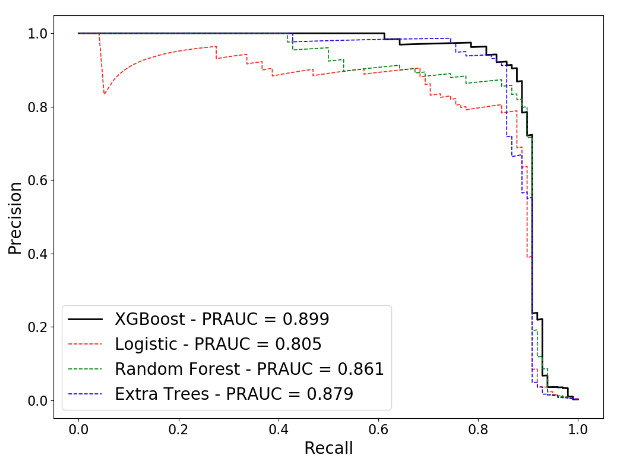

It is clear from the figure that the PR curve for our **XGBoost classifier** (solid black line) dominates all other curves almost everywhere and especailly at high recall rates. For example, if we relax our minimum precision requirement to 3%, XGBoost would provide a recall of nearly 98% while the best alternative algorithm would still have a recall below 94%.

The PRAUC metric also shows that, overall, **XGBoost performs considerably better than the other algorithms.**

The setup and parameter optimization for Logistic Regression, Random Forest and Extra Trees classifiers are explained in the appendix.

# 7. Thresholding and Prediction

Given that we face a cost-sensitive classification problem, where false negatives (missing fraud) are considerably more costly than false positives, empirical thresholding can be used to tune the classification threshold (the probability above which an example is classified as positive) and maximize the probability of detecting fraud (recall), subject to the minimum required precision.

Essentially, this treats the classification threshold like an additional hyper-parameter that needs to be tuned by cross validation. To do this, I apply a K-fold cross validation to all training data and predict probabilities of all training examples. I will then pick the classification threshold that maximizes recall, subject to satisfying the precision constraint.

The following function implements this technique for a given estimator:

In [ ]:
def optimal_threshold(estimator, X, y, n_folds = 10, min_prec = 0.05, fit_params = None):
    
    cv_pred_prob = cross_val_predict(estimator, X, y, method='predict_proba',
                                     cv = n_folds, fit_params=fit_params, n_jobs=-1)[:,1]

    # Once again, the PR curve is discreet and may not contain the exact precision level
    # we are looking for. So, we need to find the closest existing precision
    pr, _, threshold = precision_recall_curve(y, cv_pred_prob)
    # precision is always one element longer than threshold and the last one is always set to 1
    # So I drop the last element of precision so I can use it below to index threshold
    pr = pr[:-1]
    return min(threshold[pr >= min_prec])

Given the classification threshold from this process we will predict an example as positive (fraud) if the model predicts its probability of being so abvoe this threshold. It is convenient to wrap this inside a function:

In [ ]:
def thresholded_predict(X, estimator, threshold):
    return np.array([1 if (p >= threshold) else 0 for p in estimator.predict_proba(X)[:,1]])

# 8. Putting the Pieces Together and Testing the Model

We can now put everything together and build our classifier

In [ ]:
if __name__ == "__main__":    
    # Loading the data
    data = pd.read_csv('/Users/nam/Downloads/creditcard 2.csv')
    X = data.drop('Class', axis = 1)
    y = data['Class']
    
    # Train/test split, 80/20, random_state set for reproducibility
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,
                                                        test_size = 0.2, random_state = 1)

    # Further splitting the initial training set so that 10% of all data(1/8 of 80%) 
    # can be used as the evaluation set by XGBoost for early stopping
    X_train, X_early_stop, y_train, y_early_stop = train_test_split(X_train, y_train,test_size = 1/8,
                                                                    stratify = y_train, random_state = 1)
    
    # The prior probability distribution of parameters for Bayesian optimization
    param_space = {
            'learning_rate': hyperopt.hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
            'max_depth': hyperopt.hp.choice('max_depth', [2, 4, 6, 8, 10]),
            'subsample': hyperopt.hp.uniform('subsample', 0.25, 1),
            'colsample_bytree': hyperopt.hp.uniform('colsample_bytree', 0.7, 1.0),
            'min_child_weight': hyperopt.hp.choice('min_child_weight', [1, 3, 5, 7]),
            'reg_alpha': hyperopt.hp.uniform('reg_alhpa', 0, 1.0),
            # Avoiding lambda = 0. There is a Github issue on strange behaviour with lambda = 0
            'reg_lambda': hyperopt.hp.uniform('reg_lambda', 0.01, 1.0),
            }

    # # # # # # # # #
    # Step 1: Tuning hyper-parameters of the XGBoost classifier
    # # # # # # # # #
    print('Step 1: Tuning hyper-parameters using Bayesian Optimization\n')

    best_params = tune_xgb(param_space, X_train, y_train, X_early_stop, y_early_stop, n_iter = 150)
    
    print('\tThe best hyper-parameters found:\n')
    print(*['\t\t%s = %s' % (k, str(round(v, 4))) for k, v in best_params.items()], sep='\n')

    # # # # # # # # #
    # Step 2: Empirical thresholding: finding optimal classification threshold
    # # # # # # # # #
    print('\nStep 2: Empirical Thresholding\n')
    
    # I use 1500 trees which is very close to optimal n_trees found by early stopping while tuning
    xgboost_clf = XGBClassifier(**best_params, n_estimators=1500)
    
    classification_cutoff = optimal_threshold(xgboost_clf, X_train, y_train, min_prec = MIN_PRECISION)
    
    print('\tOptimal classification threshold = %1.3f' % classification_cutoff)
    
    # # # # # # # # #
    # Setp 3: Training and testing the model
    # # # # # # # # #
    print('\nStep 3: Training and testing the model\n')
    
    # Training on all the training data (excluding the small validation set to avoid overfitting)
    xgboost_clf.fit(X_train, y_train, verbose = False)
    
    y_pred = thresholded_predict(X_test, xgboost_clf, threshold = classification_cutoff)
    
    test_recall = recall_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    
    print('\tTest set performance:')
    print('\tRecall    = %2.3f' % test_recall)
    print('\tPrecision = %2.3f' % test_precision)

Note: The second split of the data creates the small validation set, discussed above, for early stopping by XGBoost. See the discussion under "Tuning by Cross Validation" above for more details.

## 8.1 Results

The last step of the code above measures the performance of the model on a held-out, never before seen, test set. The following is the output of the code.

![Screenshot 2024-11-11 at 6.08.22 AM.png](<attachment:Screenshot 2024-11-11 at 6.08.22 AM.png>)
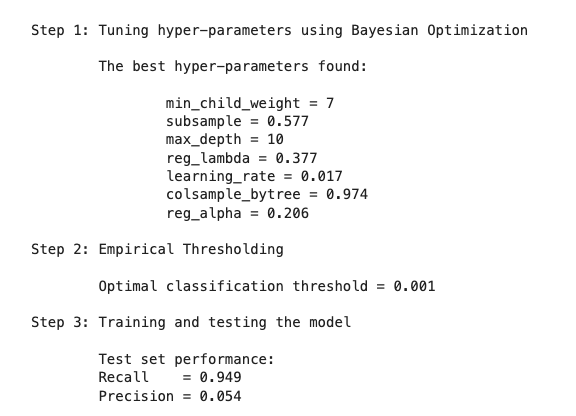

(Note that, even though we set the minimum required precision to 5%, precision on test set is only going to be close to 5% but will almost never exactly equal to it. This is because the classification threshold - which in turn determines precision - is chosen empirically by cross validation on training data which does not guarantee the exact same precision on the test set.)

The following table summarizes and compares the performance of XGBoost with some other commonly used classification algorithms. All of the other classifiers have also been empirically thresholded to provide a fair comparison. Therefore, we only need to compare their recall rates, given that they have all been tuned to target a precision level of about 5%.

![Screenshot 2024-11-11 at 6.09.07 AM.png](<attachment:Screenshot 2024-11-11 at 6.09.07 AM.png>)

Table 1. Comparing classifiers. The table reports condition recall, i.e. recall at the targeted level of precision.
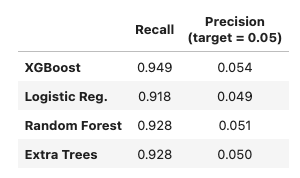

# 9. Conclusion

I used the XGBoost algorithm to detect fraudulent credit card transactions in a highly imbalance dataset where fraud examples constitute only 0.172% of examples. Bayesian hyper-parameter optiization was used to efficiently tune the model. Given the importance of detecting as many instances of fraud as possible in this application, I evaluated models based on their recall rate at a given level of precision. I used empirical thresholding to tune the trade-off between precision and recall and acheive the highest recall subject to satisfying the precision constraint. I also compared the performance of XGBoost to a few other popular classification algorithms and showed that XGBoost outperforms all of them, especially at high recall rates.

# Appendix

This appendix describes the setup uesd to train the algorithms that I compared XGBoost to, namely, Logistic Regression, Random Forest and Extra Trees. The following pieces of code are only meant for exposition and cannot be run independently.

**N.B.**: The variables `X_train_all` and `y_train_all` were not defined above. In what follows, they refer to the original training data (before the second split that creates the XGBoost validation set).

## A.1 Logistic Regression
To compensate for the class imbalance in training data, I use SMOTE oversampling for Logistic Regression. The following sets up a pipeline that 1. normalizes the data, 2. oversamples with SMOTE and 3. fits a Logistic Regression.

A simple grid search is then conducted to find the optimal value for the regularization parameter C. Finally, the precision-recall curve and the PRAUC statistic are calculated in the end.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve, auc, make_scorer
from sklearn.model_selection import GridSearchCV

logistic_clf = Pipeline(steps = [('Scaler', StandardScaler()),
                                 ('Sampler', SMOTE()),
                                 ('Logistic', LogisticRegression())])

param_grid = {'Logistic__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

scorer = make_scorer(recall_at_precision, needs_proba=True)

grid_search = GridSearchCV(logistic_clf, param_grid, cv = 10,
                           scoring = scorer, refit = True, n_jobs=-1)

grid_search.fit(X_train_all, y_train_all)

# Because of refit = True in GridSearchCV the best estimator has already been fitted to training data
scores = grid_search.best_estimator_.predict_proba(X_test)[:,1]
pr, rc, thrs = precision_recall_curve(y_test, scores)
pr_auc = auc(rc, pr)

## A.2 Random Forest and Extra Trees

The Random Forest classifier and the Extra Trees classifiers were set up and tuned as follows. Since the parameter values used were identical for these two, I will only present the setup for Random Forest. The setup for Extra Trees was exactly the same.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, auc, make_scorer
from sklearn.model_selection import GridSearchCV

forest_clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1)

param_grid = {'max_features': [None, 'sqrt', 15],
              'min_samples_leaf': [1, 20, 50, 100],
              'max_depth': [4, 10, 20, None]}

grid_search = GridSearchCV(forest_clf, param_grid, cv = 10,
                           scoring = scorer, refit=True)

grid_search.fit(X_train_all, y_train_all)

scores = grid_search.best_estimator_.predict_proba(X_test)[:,1]
pr, rc, thrs = precision_recall_curve(y_test, scores)
pr_auc = auc(rc, pr)

The `class_weight` argument is used here to reweight the training examples and compensate for class imbalance, similar to what we did for XGBoost.

Notice that since increasing the number of trees in a Random Forest does not cause overfitting, we do not need to optimize the number of trees by cross validation. We only need to make sure that we have sufficient trees so that the error settles. After experimenting with forests with different number of trees, I chose to use 100 trees.